# Analyzing NBA Playoff Tweets
## Andrew Lujan

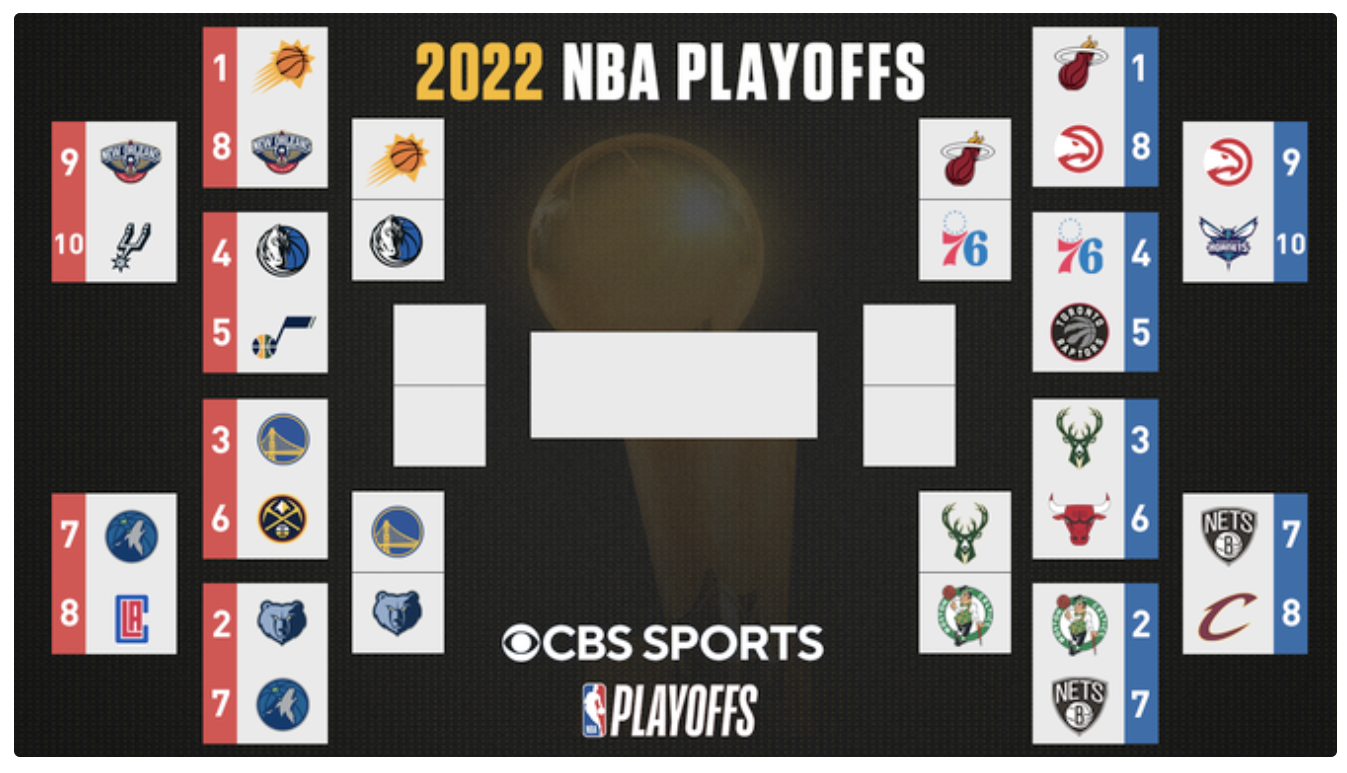

image from [CBS Sports](https://www.cbssports.com/nba/news/2022-nba-playoffs-bracket-games-today-schedule-tv-channel-live-stream-times-as-second-round-continues/)

# Introduction

Every year, the NBA season truly kicks off in the spring time for casual fans. That's no different this year with the NBA playoffs having their best first round ratings in over a decade. A lot of these rating can be attributed to the highly entertaining series between the [Boston Celtics](https://www.nba.com/celtics/) and the [Brooklyn Nets](https://www.nba.com/nets/). This got me thinking about fan's feelings during the course of the playoffs. To answer this question, I set out to scrape tweets from Twitter and visualize the most common keywords from these tweets using word clouds. Since there is a limit of how many tweets I can scrape, I decided to analyze two series, one from the Western Conference and one from the Eastern Conference. I chose the following series for the following reasons:

- Western Conference: [Phoenix Suns](https://www.nba.com/suns/) vs. [Dallas Mavericks](https://www.mavs.com/)
    * I chose this series because the Phoenix Suns are the number 1 seed in the west and are the defending conference champions. I'd like to see how their tweets compare to that of the underdog Dallas Mavericks. 
- Eastern Conference: [Milwaukee Bucks](https://www.nba.com/bucks) vs. [Boston Celtics](https://www.nba.com/celtics/)
    * There's a bit of bias in the series. Personally, I'm a huge Milwaukee Bucks (DEFENDING CHAMPS!). However, they are the underdog in this matchup as the Boston Celtics have had quite the season. The Bucks are the defending champs and have playoff pedigree, but the Celtics have had the better season and are coming of age. 

Project workflow:

* Define key functions used to collect and clean data
* I'll have to collect data from Twitter using the Tweepy package in Python. 
* From there I will clean the tweets using NLP (natural language processing)
* List the 50 most frequent words from that data and visualize them with a word cloud
* Identify the optimum number of clusters
* Cluster the tweets using Kmeans and HCA (Hierarchical Clustering Analysis)
* Based on the results of HCA I'll visualize a dendrogram
* Summarize my findings

# Research Questions
- Which players have fans been tweeting about the most?
- Which team seems to have the advantage?
- Have there been any key events in each series?
- What words seem to be trending the most in each series?

## Next steps:



# Scraping Tweets

* First, the code defines a function get_nba_data(passing in nba) as an argument. 
* Within that function I import tweepy, oauthhandler within tweepy and pandas. 
* I also pass in my twitter api keys that I can use to pull information from twitter with. 
* Then the function creates an empty dataframe called tweet_df
* From there, I create a for loop that will utilize the tweepy cursor to iterate through tweets.
* The last part of the function appends the tweet data to the empty list created.

In [125]:
# Import Needed Packages
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
import string

def get_nba_data(nba):
    # import the tweepy package and pandas
    import tweepy
    from tweepy import OAuthHandler
    import pandas as pd
    
    # Twitter API information
    consumer_key = 'gLri3OaMHbwtE8aIWYgRZEuuh'
    consumer_secret = 'p8h24rh66lcyf9afFpv6JNeBJQSNvcHhQN3JQi7AYNOXNz9ngR'
    access_token = '1322330920955781121-eOHp3JgmMN5JXfTFRtvgWkhU7bHAho'
    access_token_secret = 'ss2ksEuoyAPLTZYVATjYdrPOlzrFtjlLx2C3WpGdJaIXd'
    
    # Setup for pulling scraping tweets
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth,wait_on_rate_limit=False)
    
    # Pass tweets into this empty list
    tweet_df=[]
    
    # For each tweet we'll create a date column and the column containing the tweet
    for tweet in tweepy.Cursor(api.search_tweets,q=nba,
                               lang="en").items():
        tweet_df.append(pd.DataFrame(data=[(tweet.created_at,tweet.text)],
                                     columns=['date','tweet']))  

    # append all the individual df into one df
    tweet_data = pd.concat(tweet_df)
    tweet_data.reset_index(inplace=True, drop=True)
    
    return tweet_data

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/drewsdesktop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/drewsdesktop/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Cleaning Tweets

The code below is a clean tweets function. 
* First, it imports the library spacy
* Then it stores the English library needed for Natural language processing as NLP. 
* Additionally, the function imports nltk so that I can use the stopwords function within it.
* I also passed in additional stop words that I expect to see frequently like NBA in both cases, the names of each team, and basketball. 
* The function then starts by removing http using regex and the lambda function.

In [126]:
# simple clean tweets function -- spacy lowercases, removes stopwords, lemmatizes
# The input for this function will be the tweets generated, the output will be the tweet cleaed. Stripped of punctuation difference, numbers, stopwords, and lemmatization applied
def clean_tweets(docs):
    # import stuff
    import spacy
    nlp = spacy.load('en_core_web_sm')
    import nltk
    import re
    import string
    
    # setup the set of stopwords for tweets
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords = set(stopwords + ['rt','RT','basketball','NBA','Milwaukee', 'Mil','Bucks','Boston', 'Bos','Celtics', 'Golden State', 'Dallas', 'Dal', 'Mavericks', 'PHX', 'Phoenix', 'Suns', 'nba'])
    
    # removing http
    # communicate back where the function is
    print('Taking care of http,https,@username,#tag...')
    no_http_docs = docs.apply(lambda x: re.sub('http://\S+', '', x))
    no_https_docs = no_http_docs.apply(lambda x: re.sub('https://\S+', '', x))
    no_html_docs = no_https_docs.apply(lambda x: re.sub('@\S+', '', x))
    no_hash_tag = no_html_docs.apply(lambda x: re.sub('#\S+', '', x))
    
    # cleanup punct and numbers
    #communicate back where the function is
    print('Taking care of punctuation and numbers...')
    table = str.maketrans({key: None for key in 
                           string.punctuation + string.digits})
    clean_docs = [d.translate(table) for d in no_hash_tag]
 
    # communicate back 
    print('Doing nlp(spacy)...')
    nlp_docs = [nlp(d) for d in clean_docs]
    
    # keep the word if it's a pronoun, spacy substitutes '-PRON-' for pronouns 
    # communicate back
    print('Lemmatization...')
    lemmatized_docs = [[w.lemma_ if w.lemma_ != '-PRON-'
                           else w.lower_
                           for w in d]
                      for d in nlp_docs]
    
    # cleaning up stopwords
    # communicate back
    print('Removing stopwords...')
    lemmatized_docs = [[lemma for lemma in doc if lemma not in stopwords] 
                       for doc in lemmatized_docs]
         
    # make one doc and send it back
    clean_docs = [' '.join(l) for l in lemmatized_docs]
    return clean_docs

# Vectorization
The function below is used to create a sorted list of words and their frequencies. 
* First, within that function the CountVectorizer function is imported. This function converts a collection of text documents to a matrix of token counts
* Then using a token list that will be created later, the vectorizer function will create a vocabulary that will be stored in the variable vec. 
* Additionally, using the transform function on vec we creat a bag of words. 
* Then, using that bag of words a frequency of those words is generated using the sum function. 
* Finally, using a tuple I created a word_freq containing the word it's frequency and sort them using by passing the word_freq variable created and a key within a lambda function. 

In [127]:
# Function to take a tokenized list and returns a sorted list of words and their frequency.
# Source for this code: https://machinelearningmastery.com/prepare-text-data-machine-learning

def word_frequency(token_list):
    # more imports for the stuff below
    import string
    from sklearn.feature_extraction.text import CountVectorizer 

    # Choose the vocabulary to be used
    vec = CountVectorizer().fit(token_list)
    # Encode the text using bag of words.
    BoW = vec.transform(token_list)
    # Determine frequencies of words.
    FoW = BoW.sum(axis=0)
    # Tuple Creation. Within the tuple we have the word, frequence
    word_freq = [(word, FoW[0, idx]) for word, idx in vec.vocabulary_.items()]
    # Sort the tuple
    sorted_word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    
    return sorted_word_freq

# Cleaning for odd characters
The code below is used to remove non alpha_numeric characters. It does so through:
   * The use of a for loop that will run through tweets for the length clean_tweets. Then using the findall method it seeks out non alphanumeric chracters and stores them in a variable called filter_out. 
   * Lastly, the function loops through the filter out list and removes any non space characters. 

In [129]:
# Cleaning up odd characters and sequences
# Will taken in a tweet and remove odd characters
def weird_characters(clean_tweets):

    # Import stuff
    import re

    # Defining our regex pattern. Any non-alphanumeric characters
    spec_char = re.compile(r'\W')

    print('Removing weird characters ... ')
    
    # Loop through clean tweets and apply the regex pattern
    for i in range(len(clean_tweets)):
        filter_out = spec_char.findall(clean_tweets[i])

        # Loop through filter_out, if no white space, compile the values in a new variable called clean_out
        for k in range(len(filter_out)):
            if (filter_out[k]!=' '):
                clean_out=re.compile(filter_out[k])
                
                #print(I, K, clean_out.findall(clean_tweets[i]))
                clean_tweets[i]=clean_out.sub(' ',clean_tweets[i])
    
    return(clean_tweets)

# Wordcloud function

The function below is used to create a word cloud. 
* The function takes in a cloud png file and creates a word cloud over it by first converting the function into an array.
* After doing that, the function allows for us to draw the words on to the white parts. 
* Then the function counts the word frequency for the text that will be used with the function. It also counts the most common words sorts them. 

In [130]:
# Make a word cloud of the 50 most frequently used words
def make_cloud(text_list,top):
    # Import needed libraries  
    from PIL import Image
    import numpy as np
    import nltk
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    # Cloud png file that will be used as a mask. 
    im_mask = Image.open('cloud.png')
    # Scale up the mask to improve resoluation
    im_mask = im_mask.resize((im_mask.size[0]*3, im_mask.size[1]*3), Image.ANTIALIAS)

    # Convert the mask to a numpy array and then flatten it out
    # Using two colors mainly 0 and 255
    im_mask = np.array(im_mask)
    max(im_mask.flatten())
    im_mask[im_mask > 50] = 255
    
    # Change the colors so that we can draw on the canvas
    im_mask = np.invert(im_mask) 
    
    # Count the frequency for each token
    wordcount = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(text_list)))
    # Find most frequent words
    word_freq = wordcount.most_common(top)
    # Sort them
    sorted_word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)

    # Cloud construction
    cloud = WordCloud(background_color="white", height= 1800, 
                      width = 1000, mask=im_mask)
    mycloud = cloud.generate_from_frequencies(dict(sorted_word_freq))

    # Plot the cloud
    plt.figure(figsize=(10, 13))
    plt.imshow(mycloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Vectorizing Features
The function below will convert the text files into a matrix of TF-IDF features.
- Term Frequency: Frequency of the words in the dataset. Used to calculate the importance of a word in a dataset.
- Inverse Document Frequency: Determines total number of terms in the document, also used in calcuation. 

The calculation can be explained [here](https://medium.com/acing-ai/what-is-tf-idf-in-feature-engineering-7f1ba81982bd#:~:text=It%20has%20two%20parts%3A%20Term,in%20the%20document%20or%20dataset.&text=The%20second%20part%20is%20%E2%80%94%20inverse,word%20is%20to%20the%20document.), but I've also listed it below.

TF * IDF = [ (Number of times term t appears in a document) / (Total number of terms in the document) ] * log10(Total number of documents / Number of documents with term t in it).

In [131]:
# determine the TF-IDF features of text
def tfidf_features(text_list):
    # import stuff
    from sklearn.feature_extraction.text import TfidfVectorizer

    # establish an instance
    vec = TfidfVectorizer()

    # fit and transform the tweets
    features = vec.fit_transform(text_list)
 
    # convert to a numpy dense matrix will be easier later
    features = features.todense()
    
    # debugging
    #print(type(features))
    #print(features)
    
    return(features)

# Determining the optimal clusters

The function in the code below will be used to find the optimal number of clusters as it is named. 
* First, it will import the Kmeans function from the sklearn.cluster library. It will also import matplotlib for visualization.
* Additionally, the function will create an empty list called sum_sq. The list will be appended with the score for each model at the end of a for loop. 
* Next, the function creates a for loop that will run trhough a specified range and while doing so print  calculating for # clusters. 
* Then, we will fit the model to the dataset and append the model score to the list sum_sq that was created earlier. 
* Then, the function will visualize the optimum number clusters by passing in the range, and the list of clusters into a scatter chart. it will also apply the diff method on the list that was created earlier (sum_sq).

* The last part of the function compares the the original plot against the diff plot.  

In [134]:
# Function to find optimal clusters

def find_optimal_clusters(dataset,range_lower, range_upper):
    # Loop between 2 and 30 clusters

    # Import needed packages
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    %matplotlib inline

    # List for optimal number of clusters. Used with the sum of squares
    sum_sq= []

    # Fit the model and append the value to sum_sq
    for n in range (range_lower,range_upper):
        print('Calculating for ',n,' clusters')

        model = KMeans(n_clusters=n, random_state=42) # set the random state to make results reproducible
        model.fit(dataset)
        sum_sq.append(-model.score(dataset))
        
    # Scree plot to determine optimal clusters
    plt.scatter(range(range_lower, range_upper), sum_sq)
    np.diff(sum_sq)
    sum_sq
    plt.show()
    
    # Comparison diff plot for scree plot above
    plt.scatter(range((range_lower +1), range_upper), np.diff(sum_sq))
    plt.show()
    
    return

# Scraping Tweets

The first part of the project will be extracting Tweets. I'll extract tweets for the following teams listed before:
- Milwaukee Bucks
- Boston Celtics
- Phoenix Suns
- Dallas Mavericks

In [136]:
# Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data Visualzation
import seaborn as sns

%matplotlib inline

In [63]:
# Gather the Twitter data for a specific team: Milwaukee Bucks

import time

# calling get_nba_data()
mil_data = get_nba_data('#MilwaukeeBucks')

# display the df
display(mil_data.head(10))
display(mil_data.tail(10))

# debugging: see what we have
print("Milwaukee Bucks", mil_data.shape)
time.sleep(1)

TooManyRequests: 429 Too Many Requests
88 - Rate limit exceeded

First, using the get NBA data function that was made earlier, I pulled in tweets using the #MilwaukeeBucks hashtag.

In [ ]:
# Gathering twitter data for Phoenix Suns

# calling get_nba_data()
phx_data = get_nba_data('#PhoenixSuns')

# display the df
display(phx_data.head(10))
display(phx_data.tail(10))

# debugging: see what we have
print("Phoenix Suns", phx_data.shape)
time.sleep(1)

Pulled in tweets using the #PhoenixSuns hashtag. 

In [52]:
# Gather the Twitter data for Boston Celtics. 

# calling get_nba_data()
bos_data = get_nba_data('#BostonCeltics')

# display the df
display(bos_data.head(10))
display(bos_data.tail(10))

# debugging: see what we have
print("Boston Celtics", bos_data.shape)

,date,tweet
0,2022-05-12 16:55:23+00:00,Game 6. Friday Night. Let’s play some basketba...
1,2022-05-12 16:32:53+00:00,Thought @jaytatum0 was gonna take that next st...
2,2022-05-12 16:30:05+00:00,At #27 of my #NBA75 series is an indefatigable...
3,2022-05-12 16:26:46+00:00,RT @ittledomerc: Excited to share this item fr...
4,2022-05-12 16:24:46+00:00,RT @ittledomerc: Excited to share this item fr...
5,2022-05-12 16:03:35+00:00,"“Nooo, I don’t wanna go to Boston” Celtics sta..."
6,2022-05-12 15:26:58+00:00,Excited to share this item from my #etsy shop:...
7,2022-05-12 15:05:53+00:00,Great night out in Boston with our friends Pet...
8,2022-05-12 14:30:39+00:00,Resumen Boston Celtics vs Milwaukee Bucks Jueg...
9,2022-05-12 14:09:11+00:00,🔴#NBA🏀🇺🇲\n🔴#PlayOffs\n🔴#East SemiFinals\n#Game...


,date,tweet
640,2022-05-07 22:15:55+00:00,These are the worst fucking refs ever. #Boston...
641,2022-05-07 22:15:25+00:00,Wild game 🤯 #MilwaukeeBucks #BostonCeltics #nba
642,2022-05-07 22:14:47+00:00,Tatum gacked all over this game. HORRIBLE #Bos...
643,2022-05-07 22:12:26+00:00,Boston must of heard me 🗣💩😂😂😂 #FearTheDeer #Bo...
644,2022-05-07 22:10:22+00:00,#BostonCeltics playing hard this game to good ...
645,2022-05-07 22:09:44+00:00,Most of these fouls are soft #BostonCeltics #M...
646,2022-05-07 22:06:11+00:00,Ime Udoka is coaching a masterpiece in this ga...
647,2022-05-07 22:04:16+00:00,This game calling is turrible **Charles Barkle...
648,2022-05-07 22:03:01+00:00,#NBAPlayoffs #NBA75 #BostonCeltics Al Horford 🔥
649,2022-05-07 22:02:48+00:00,Let’s go Celtics #BostonCeltics #BOSvsMIL


Boston Celtics (650, 2)


## Observing raw Celtics tweets

Pulled in tweets related to the Boston celtics. You can see here that we have a date column and tweet column as specified before. Some of the first entries talk about:
- Game 6
- Jayson Tatum (key Celtics player)
- #NBA75 hashtag

In [53]:
# Gather the Twitter data for Dallas Maverics

# calling get_nba_data()
dal_data = get_nba_data('#DallasMavs')

# display the df
display(dal_data.head(10))
display(dal_data.tail(10))

# debugging: see what we have
print("Dallas Mavericks", dal_data.shape)
time.sleep(1)

,date,tweet
0,2022-05-12 14:11:15+00:00,Win or Stay Home\n\n#DallasMavs vs. #Suns Game...
1,2022-05-12 13:23:39+00:00,@SexyNatG any way you can bring that same ener...
2,2022-05-12 06:43:12+00:00,RT @fighthubjahir: Is it true that they callin...
3,2022-05-11 23:15:53+00:00,RT @blogaccess1on1: This was exactly the type ...
4,2022-05-11 23:15:36+00:00,This was exactly the type of performance the @...
5,2022-05-11 20:31:24+00:00,Suns head back hostile territory vs. Mavericks...
6,2022-05-11 16:09:12+00:00,RT @fishsports: Oh-Oh. LUKA VS. BOOKER is ON.\...
7,2022-05-11 15:49:04+00:00,Oh-Oh. LUKA VS. BOOKER is ON.\n\nVIDEO: #LukaD...
8,2022-05-11 06:18:20+00:00,GAME 5 SEMIS: suns 110 MAVERICKS 80 (suns domi...
9,2022-05-11 05:48:59+00:00,Where Is Jason Kidd Ex Wife Joumana Kidd Now? ...


,date,tweet
176,2022-05-05 02:29:04+00:00,RT @MacEngelProf: In case you are wondering ho...
177,2022-05-04 23:06:05+00:00,Waiting for tonight… for game 2! ✌️\n\nShop Ni...
178,2022-05-04 21:00:01+00:00,"Shop #MFFL Frames, Puzzles, Prints, Phones C..."
179,2022-05-04 19:40:40+00:00,#NBA75- #NBAPlayoffs2022- Rd.2: #PhoenixSuns/#...
180,2022-05-04 19:12:18+00:00,Suns' Game 2 odds shorten ahead of hosting Mav...
181,2022-05-04 18:51:35+00:00,RT @dallasmavsshop: Wishing the happiest of bi...
182,2022-05-04 17:37:23+00:00,RT @dallasmavsshop: Wishing the happiest of bi...
183,2022-05-04 16:35:58+00:00,RT @dallasmavsshop: Wishing the happiest of bi...
184,2022-05-04 15:18:50+00:00,RT @dallasmavsshop: Wishing the happiest of bi...
185,2022-05-04 15:17:09+00:00,Wishing the happiest of birthdays to the one a...


Dallas Mavericks (186, 2)


# Observing raw Mavericks Tweets

The first few tweets related to the Dallas Mavericks talk about:
- Win or Stay home. The Mavs are currently on the brink of elimination. 
- Suns returning to Dallas in hostile territory. 
- Tweets about Luka Doncic. 

In [64]:
# Code prints out the number of tweets collected under the tweet feature. 
mil_tweets = mil_data['tweet']
phx_tweets = phx_data['tweet']
bos_tweets = bos_data['tweet']
dal_tweets = dal_data['tweet']

# debugging: check how much data we have
print("Milwaukee Tweets length:",len(mil_tweets))
print("Phoenix Tweets length:",len(phx_tweets))
print("Boston Tweets length:",len(bos_tweets))
print("Dallas Tweets length:",len(dal_tweets))

Milwaukee Tweets length: 452
Phoenix Tweets length: 1047
Boston Tweets length: 650
Dallas Tweets length: 186


It looks like we scraped a total of 452 tweets for Milwaukee, 1047 for Phoenix, 650 for Boston, and 186 for Dallas. Next, what we are going to do is clean the tweets. We're going to strip the domain name, weird characters, #tags, remove stops words, remove white spaces, and lemmatizing (grouping inflected forms of words).

# Cleaning Tweets

In [80]:
# cleaning the mil_tweets dataset, pass to clean_tweets()
nlp_mil_tweets = clean_tweets(mil_tweets)

# stripping out all the weird characters, pass to weird_characters()
clean_mil_tweets = weird_characters(nlp_mil_tweets)

# debugging: look at the first 10 tweets
print(clean_mil_tweets[:10])
#print(type(clean_mil_tweets))
print(len(clean_mil_tweets))

Taking care of http,https,@username,#tag...
Taking care of punctuation and numbers...
Doing nlp(spacy)...
Lemmatization...
Removing stopwords...
Removing any weird characters ...
['I like city   really dislike   I  m become buck fan right    ', 'Middleton back full form start     repeat back back  ', 'Coach Bud vibe today           ', '  really say I take ball go home          ', '   Holiday defensive beast   game     ', 'love get close championship      ', 'Resumen vs Juego   Playoffs     ', 'game   see y    tomorrow     ', '          SemiFinals                        AL HORFORD      ', '  Listen I  m glad y  sit Grayson Allen lmao      ']
452


In [81]:
# cleaning the phx_tweets dataset, pass to clean_tweets()
nlp_phx_tweets = clean_tweets(phx_tweets)

# stripping out all the weird characters, pass to weird_characters()
clean_phx_tweets = weird_characters(nlp_phx_tweets)

# debugging: look at the first 10 tweets
print(clean_phx_tweets[:10])
#print(type(clean_phx_tweets))
print(len(clean_phx_tweets))

Taking care of http,https,@username,#tag...
Taking care of punctuation and numbers...
Doing nlp(spacy)...
Lemmatization...
Removing stopwords...
Removing any weird characters ...
['      vs Game   odd well bet expect Phoen  ', '  GAME       vs    pm             burger amp BEER TOO    Burger amp Frie  ', 'gameday let  s go   ', 'Devin Booker Tribute        ', '     lose game  ', '    Lets wrap thing tonight fellas Lets whoop trick Seal deal', '    finish mavs tonight advance western conference final second  ', 'Game   tonight let go       ', '  need butt kick tonight     ', '  Devin Booker well   Luka Ai even close']
1047


In [82]:
# cleaning the bos_tweets dataset, pass to clean_tweets()
nlp_bos_tweets = clean_tweets(bos_tweets)

# stripping out all the weird characters, pass to weird_characters()
clean_bos_tweets = weird_characters(nlp_bos_tweets)

# debugging: look at the first 10 tweets
print(clean_bos_tweets[:10])
#print(type(clean_bos_tweets))
print(len(clean_bos_tweets))

Taking care of http,https,@username,#tag...
Taking care of punctuation and numbers...
Doing nlp(spacy)...
Lemmatization...
Removing stopwords...
Removing any weird characters ...
['Game   Friday Night Let  s play boyz         ', 'Thought   go take next step playoff maybe hit ceiling   I expect  ', '    series indefatigable warrior one great allaround player time  ', '  Excited share item   shop   Topps Basketball John Hondo Havlicek   CELTICS  ', '  Excited share item   shop   Topps Basketball John Hondo Havlicek   CELTICS  ', '  Nooo I wanna go   star Jayson Tatum reveal badly want acquire  ', 'excited share item   shop   Topps Basketball John Hondo Havlicek   CELTICS  ', 'great night friend pete AlerisLife Nick Aqueduct Technologies Cisco Meraki  ', 'Resumen vs Juego   Playoffs     ', '          SemiFinals                        AL HORFORD      ']
650


In [83]:
# cleaning the dal_tweets dataset, pass to clean_tweets()
nlp_dal_tweets = clean_tweets(dal_tweets)

# stripping out all the weird characters, pass to weird_characters()
clean_dal_tweets = weird_characters(nlp_dal_tweets)

# debugging: look at the first 10 tweets
print(clean_dal_tweets[:10])
#print(type(clean_dal_tweets))
print(len(clean_dal_tweets))

Taking care of http,https,@username,#tag...
Taking care of punctuation and numbers...
Doing nlp(spacy)...
Lemmatization...
Removing stopwords...
Removing any weird characters ...
['win stay home     vs   Game   Preview odd', '  way bring energy   game tonight ask fren entire', '  true call Booker   Kmart Kobe             ', '  exactly type performance   need        ', 'exactly type performance   need       ', 'sun head back hostile territory vs        ', '  OhOh LUKA VS BOOKER    VIDEO   Accuses   Acting Tough Devin Booker Mocks   Star http  ', 'OhOh LUKA VS BOOKER    VIDEO   Accuses   Acting Tough Devin Booker Mocks   S  ', 'GAME   SEMIS sun   MAVERICKS   sun dominate nd half take seri   via  ', 'Jason Kidd Ex wife Joumana Kidd know Actress    ']
186


# Checking data remained intact
After applying the clean tweets function on each team, I'm going to check that we have the same number of tweets as we did before we started the cleaning process. I don't want to lose any data. 

In [84]:
# Verify we still have all our data
print("Mil Tweets len:",len(clean_mil_tweets))
print("Phx Tweets len:",len(clean_phx_tweets))
print("Bos Tweets len:",len(clean_bos_tweets))
print("Dal Tweets len:",len(clean_dal_tweets))

Mil Tweets len: 452
Phx Tweets len: 1047
Bos Tweets len: 650
Dal Tweets len: 186


It looks like we are good. The next part of the process will be visualizing the most common words through the use of the wordclouds function from earlier. 

# Word Clouds

### Milwaukee Bucks

Word Cloud for Milwaukee Bucks


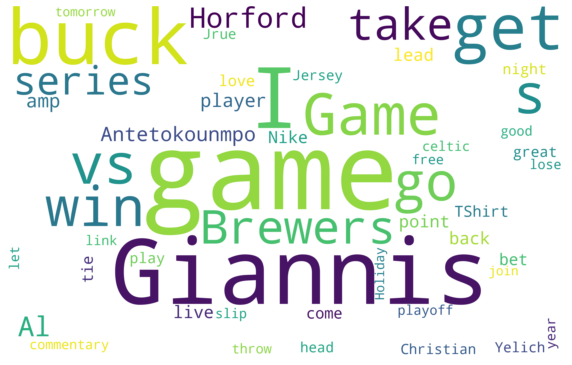

In [137]:
# Mil Tweets Word cloud
# use make_cloud() to see the top 100 words in the pros_data
print('Word Cloud for Milwaukee Bucks')
make_cloud(clean_mil_tweets,50)

## Analysis:

The 50 most common words in the word cloud above have some interesting results and some that aren't so surprising. My takeaways:
- Giannis looks like the most popular word in the cloud. Giannis the best player on the Milwaukee Bucks. 
- Win is another popular word. The Bucks currently have 3 wins to the Boston Celtics 2 wins. 
- Horford is the last name of a player on the Celtics. This isn't surprising because he was dominant in the last couple of games. 

### Boston Celtics


Word Cloud for Boston Celtics


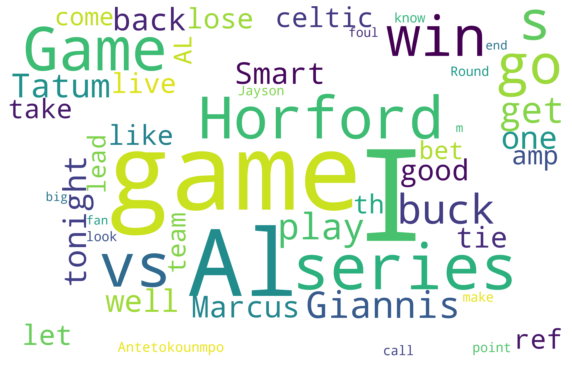

In [139]:
# Word cloud for the Boston Celtics
# use make_cloud() to see the top 100 words in the bos_data
print('Word Cloud for Boston Celtics')
make_cloud(clean_bos_tweets,50)

### Analysis:
- Al and Horford are two very prominent words. They are because of how well he played in the last two games. 
- Ref is pretty prevalent which would indicate that some of the Boston fans weren't too happy with some of the calls during the game.
- Comeback is pretty prevalent, which wouldn't be surprising. The Bucks had a massive come back against the Celtics in Game 6. 

### Phoenix Suns

Word Cloud for Phoenix Suns


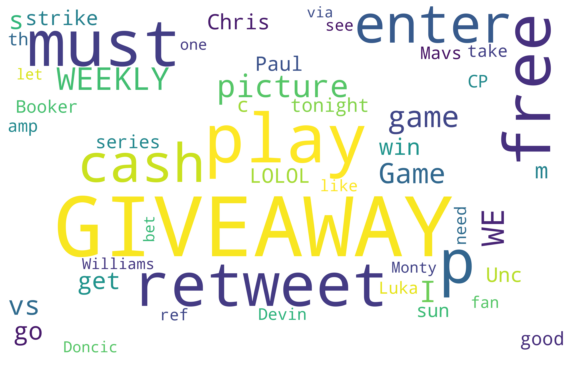

In [140]:
# Phoenix Suns
# use make_cloud() to see the top 100 words in the phx_data
print('Word Cloud for Phoenix Suns')
make_cloud(clean_phx_tweets,50)

### Analysis:
- Giveaway is a popular word. It looks like there was a big [ticket giveaway](https://fabulousarizona.com/giveaways/opendoor-phoenix-suns-ticket-giveaway/)
- Retweet is prominent as well which indicates that people needed to retweet to win tickets. 
- Paul is prevalent and he is a key player on the Phoenix Suns. 

### Dallas Mavericks

Word Cloud for Dallas Mavericks


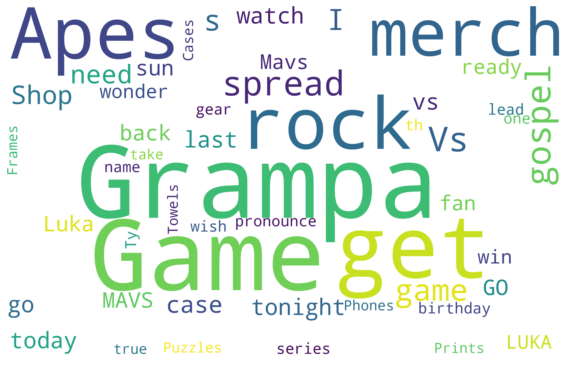

In [141]:
# Dallas Mavericks
# use make_cloud() to see the top 100 words in the dal_data
print('Word Cloud for Dallas Mavericks')
make_cloud(clean_dal_tweets,50)

### Analysis:
- The first word that pops out is Grampa. I couldn't find the source of this word being tweeted out as it pertains to the Mavericks. 
- Apes was another interesting one. This pertains to the NFT collection Boring Apes, a club that Mark Cuban belongs too. 
- Spread is also prevalent and I'm wondering if that's related to sports betting becoming more and more prevalant in America. The spread is a term in betting. 

# Combining Tweets by Conference
The next thing we are going to do is try and cluster tweets. We're going to do this for each conference in the NBA. The Eastern Conference and the Western Conference. The two east teams that I collected tweets for Boston and Milwaukee will be combined and the same will be done with the western conference teams. 

In [99]:
# Observing how many tweets were pulled from Eastern Conference
east_tweets = clean_mil_tweets + clean_bos_tweets
print("Combined Eastern Conference Tweets len:",len(east_tweets))

Combined Eastern Conference Tweets len: 1102


In [100]:
# Observing how many tweets were pulled from Western Conference
west_tweets = clean_phx_tweets + clean_dal_tweets
print("Combined Western Conference Tweets len:",len(west_tweets))

Combined Western Conference Tweets len: 1233


# Determining Optimal Number of Clusters to run Kmeans clusters and HCA on

<class 'numpy.matrix'>
Calculating for  2  clusters
Calculating for  3  clusters
Calculating for  4  clusters
Calculating for  5  clusters
Calculating for  6  clusters
Calculating for  7  clusters
Calculating for  8  clusters
Calculating for  9  clusters
Calculating for  10  clusters
Calculating for  11  clusters
Calculating for  12  clusters
Calculating for  13  clusters
Calculating for  14  clusters
Calculating for  15  clusters
Calculating for  16  clusters
Calculating for  17  clusters
Calculating for  18  clusters
Calculating for  19  clusters
Calculating for  20  clusters
Calculating for  21  clusters
Calculating for  22  clusters
Calculating for  23  clusters
Calculating for  24  clusters
Calculating for  25  clusters
Calculating for  26  clusters
Calculating for  27  clusters
Calculating for  28  clusters
Calculating for  29  clusters


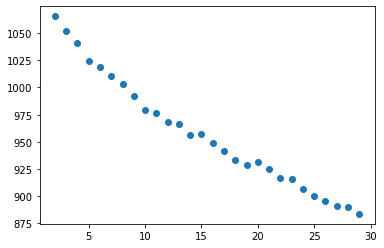

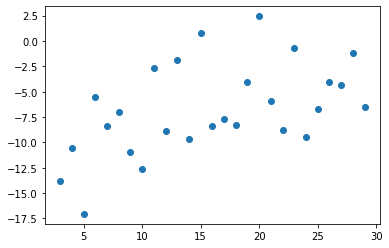

In [142]:
# use tfidf_features() to convert the text data into numerical data
eastern_features = tfidf_features(east_tweets)

# debugging
print(type(eastern_features))

#pass the features array to find_optimal_clusters() and specify the range to look for the optimal number of clusters
find_optimal_clusters(eastern_features,2,30)

### Analysis:
- Scree plots and Diff plots were generated from the function above. 
- When reading the first plot the scree plot we look for the first sign of slowed change in model quality. It looks like at around 10 or 11 clusters the model performance begins to even out. We'll choose 10 for our clusters. 
- The diff plot doesn't look particularly helpful. We would look for the first relatively flat cluster spot on the graph, but it doesn't look like it's there. 

<class 'numpy.matrix'>
Calculating for  2  clusters
Calculating for  3  clusters
Calculating for  4  clusters
Calculating for  5  clusters
Calculating for  6  clusters
Calculating for  7  clusters
Calculating for  8  clusters
Calculating for  9  clusters
Calculating for  10  clusters
Calculating for  11  clusters
Calculating for  12  clusters
Calculating for  13  clusters
Calculating for  14  clusters
Calculating for  15  clusters
Calculating for  16  clusters
Calculating for  17  clusters
Calculating for  18  clusters
Calculating for  19  clusters
Calculating for  20  clusters
Calculating for  21  clusters
Calculating for  22  clusters
Calculating for  23  clusters
Calculating for  24  clusters
Calculating for  25  clusters
Calculating for  26  clusters
Calculating for  27  clusters
Calculating for  28  clusters
Calculating for  29  clusters


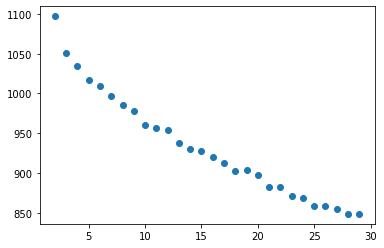

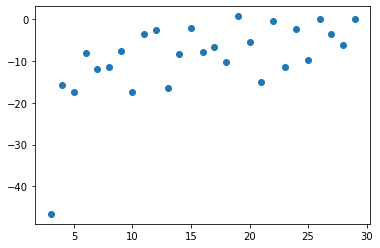

In [143]:
# use tfidf_features() to convert the text data into numerical data
western_features = tfidf_features(west_tweets)

# debugging
print(type(western_features))

#pass the features array to find_optimal_clusters() and specify the range to look for the optimal number of clusters
find_optimal_clusters(western_features,2,30)

### Analysis:
- It looks as though the model peformance normalizes at around 10 or 11 clusters as well.

# Building our Kmeans models

In [144]:
# Kmeans model with the optimal number of clusters, 10 clusters
# import stuff
from sklearn.cluster import KMeans

model = KMeans(n_clusters= 10 , random_state=42)
model.fit(eastern_features)


KMeans(n_clusters=10, random_state=42)

In [145]:
# Fit the model on the data and assign it to clusters
clusters = model.predict(eastern_features)

# Display the information
print("Cluster assignment:")
print(clusters)
print("Number of data points in each cluster:: ",np.bincount(clusters))

Cluster assignment:
[0 0 0 ... 0 8 6]
Number of data points in each cluster::  [558  84  36  28  21  97  67  63  93  55]


In [146]:
# Import necessary packages
import nltk
for i in range(len(np.bincount(clusters))):
    ind_cluster = np.array(east_tweets)[clusters == i]
    
    wordcount = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(ind_cluster)))
    word_freq = wordcount.most_common(10)
    sorted_word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    
    print('Cluster',i+1,'contains',len(ind_cluster),'tweets')
    print('   Top 10 words for this cluster:<word:frequency>')
    
    for k in range(len(sorted_word_freq)):
        print('      ',sorted_word_freq[k][0],':',sorted_word_freq[k][1])

Cluster 1 contains 558 tweets
   Top 10 words for this cluster:<word:frequency>
       I : 108
       game : 45
       s : 39
       buck : 37
       series : 33
       play : 32
       get : 31
       amp : 30
       one : 24
       Tatum : 24
Cluster 2 contains 84 tweets
   Top 10 words for this cluster:<word:frequency>
       Giannis : 84
       Antetokounmpo : 38
       get : 18
       buck : 13
       New : 9
       mural : 9
       downtown : 9
       mauriciopaint : 9
       PTS : 8
       REB : 8
Cluster 3 contains 36 tweets
   Top 10 words for this cluster:<word:frequency>
       Marcus : 26
       Smart : 26
       player : 7
       game : 7
       s : 5
       year : 5
       get : 5
       smart : 5
       ball : 5
       I : 5
Cluster 4 contains 28 tweets
   Top 10 words for this cluster:<word:frequency>
       Brewers : 28
       Nike : 15
       TShirt : 13
       Christian : 11
       Yelich : 11
       Jersey : 11
       Cream : 6
       White : 5
       NL : 5
       

### Eastern Clusters Analysis:
- **Cluster 1:** doesn't have very related information. 
- **Cluster 2:** tweets are pretty related. They talk about Giannis and the stats he excels at pts, rbs. Additionally, we see mural which might indicate that fans want there to be mural of Giannis downtown in Milwaukee at some point for all of his success. 
- **Cluster 3:** contains tweets pertaining to Marcus Smart
- **Cluster 4:** contains keywords pertaining to the Milwaukee Brewers. Christian Yelich a famous player for them must have been at the game. 
- **Cluster 5:** this cluster wasn't very insightful. Very few tweets relate to each other. 
- **Cluster 6:** talks about the games and possible days the games could be on like tomorrow. 
- **Cluster 7:** a cluster of chant related keywords.
- **Cluster 8:** a cluster talking about the Series and and possibly who is winning. The Bucks!
- **Cluster 9:** this cluster is all about Al Horford. He played really well in the series so far. 
- **Cluster 10:** this cluster of keywords talks the commentators or the broadcast. 

# Creating a similarity matrix for our dendrogram
Similarity matrixes are used to determine the similarity of a word. In this case we are using it on the words from the tweets we extracted. 

In [148]:
# calulate the simiarity for the features
similarity_matrix = 1-cosine_similarity(eastern_features)
similarity_matrix

array([[-2.22044605e-16,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00, -2.22044605e-16,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       ...,
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
        -2.22044605e-16,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  0.00000000e+00]])

# Creating a dendrogram
To visualize our clusters and the groups within them we'll use a dendrogram to show the hierachical clustering that is happening. 

{'icoord': [[185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [165.0, 165.0, 182.5, 182.5],
  [155.0, 155.0, 173.75, 173.75],
  [145.0, 145.0, 164.375, 164.375],
  [135.0, 135.0, 154.6875, 154.6875],
  [125.0, 125.0, 144.84375, 144.84375],
  [115.0, 115.0, 134.921875, 134.921875],
  [105.0, 105.0, 124.9609375, 124.9609375],
  [95.0, 95.0, 114.98046875, 114.98046875],
  [85.0, 85.0, 104.990234375, 104.990234375],
  [75.0, 75.0, 94.9951171875, 94.9951171875],
  [65.0, 65.0, 84.99755859375, 84.99755859375],
  [55.0, 55.0, 74.998779296875, 74.998779296875],
  [45.0, 45.0, 64.9993896484375, 64.9993896484375],
  [35.0, 35.0, 54.99969482421875, 54.99969482421875],
  [25.0, 25.0, 44.999847412109375, 44.999847412109375],
  [15.0, 15.0, 34.99992370605469, 34.99992370605469],
  [5.0, 5.0, 24.999961853027344, 24.999961853027344],
  [245.0, 245.0, 255.0, 255.0],
  [235.0, 235.0, 250.0, 250.0],
  [225.0, 225.0, 242.5, 242.5],
  [215.0, 215.0, 233.75, 233.75],
  [205.0, 205.0, 224.375, 

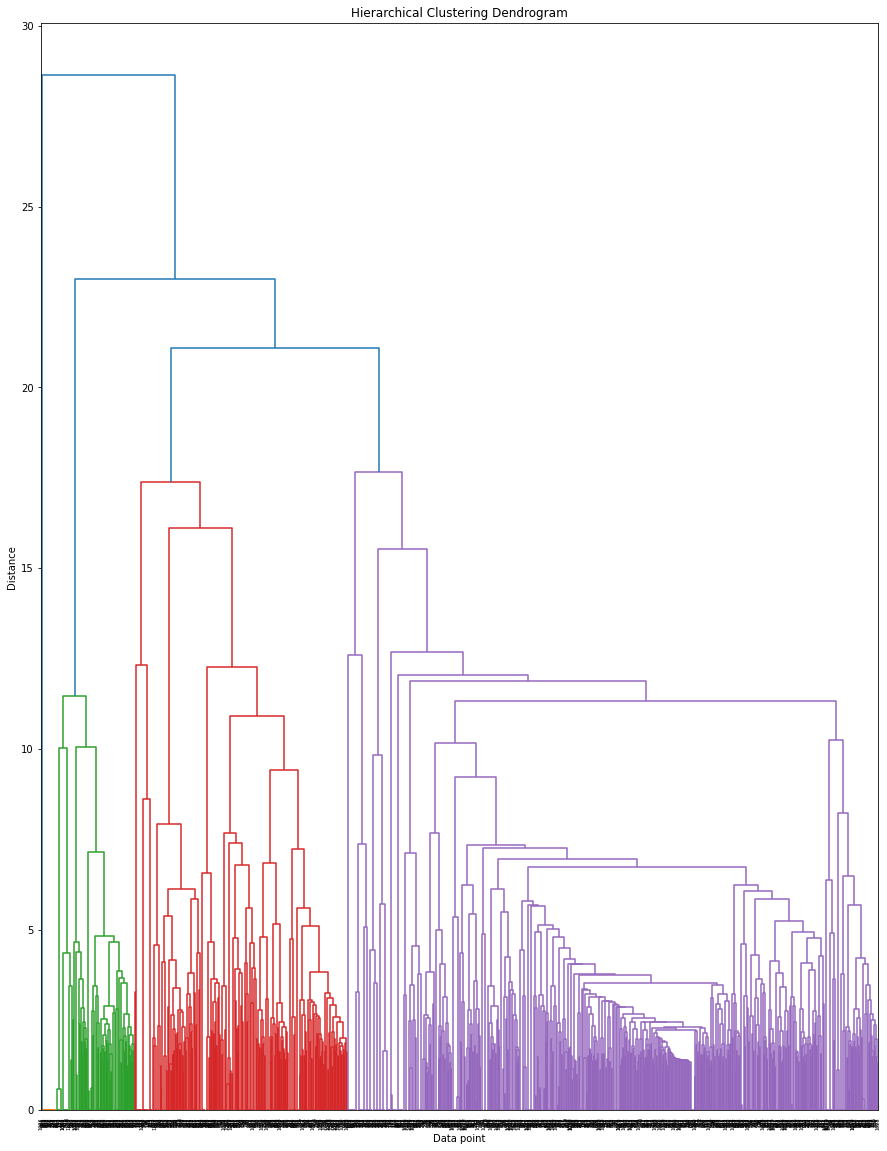

In [154]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(similarity_matrix, 'ward')


plt.figure(figsize=(15, 20))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)

### Analysis:
- It's hard to really extract any information from the dendrogram. The main thing to takeaways is that there are quite a few related words and you can see that by the different groups forming across the dendrogram.

# West Conference Clustering
- We'll do a similary clustering and analysis for the Western Conference tweets now. 

In [156]:
model = KMeans(n_clusters=10 , random_state=42)
model.fit(western_features)

KMeans(n_clusters=10, random_state=42)

In [157]:
# look at the cluster assignments
clusters = model.predict(western_features)

# Display the information
print("Cluster assignment:")
print(clusters)
print("Number of data points in each cluster:: ",np.bincount(clusters))

Cluster assignment:
[3 3 0 ... 7 7 7]
Number of data points in each cluster::  [651  21  16 186  48  76 115  55  41  24]


In [158]:
for i in range(len(np.bincount(clusters))):
    ind_cluster = np.array(west_tweets)[clusters == i]
    
    wordcount = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(ind_cluster)))
    word_freq = wordcount.most_common(10)
    sorted_word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    
    print('Cluster',i+1,'contains',len(ind_cluster),'tweets')
    print('   Top 10 words for this cluster:<word:frequency>')
    
    for k in range(len(sorted_word_freq)):
        print('      ',sorted_word_freq[k][0],':',sorted_word_freq[k][1])

Cluster 1 contains 651 tweets
   Top 10 words for this cluster:<word:frequency>
       I : 92
       get : 70
       s : 60
       go : 59
       need : 36
       fan : 34
       good : 32
       Luka : 31
       win : 31
       sun : 29
Cluster 2 contains 21 tweets
   Top 10 words for this cluster:<word:frequency>
       Jersey : 20
       Custom : 14
       Incredible : 6
       Kid : 6
       deliver : 6
       powerplay : 6
       frame : 2
       jersey : 2
       good : 1
       luck : 1
Cluster 3 contains 16 tweets
   Top 10 words for this cluster:<word:frequency>
       Turner : 16
       Carreker : 16
       kid : 16
       assault : 16
       CP : 16
       s : 16
       Mother : 16
       Wife : 16
Cluster 4 contains 186 tweets
   Top 10 words for this cluster:<word:frequency>
       game : 96
       Game : 91
       vs : 47
       win : 28
       Mavs : 27
       I : 23
       tonight : 21
       sun : 19
       go : 18
       series : 15
Cluster 5 contains 48 tweets
   Top

### Western Clusters Analysis:
- **Cluster 1:** this cluster lacks related words. Perhaps because it is too big. 
- **Cluster 2:** The tweets in this cluster relate to jerseys and some of the adjectives used to describe them. 
- **Cluster 3:** cluster 3 has tweets from a completely unrelated topic. 
- **Cluster 4:** this cluster talks about the game. 
- **Cluster 5:** this cluster doesn't have highly correlated words either. 
- **Cluster 6:** cluster 6 has a couple of words related to Chris Paul. 
- **Cluster 7:** this cluster contains tweets related to the ticket giveaway we were talking about before. 
- **Cluster 8:** talks about the conference, the series, and which quarter the game was in. 
- **Cluster 9:** bet, slip and link are some of the words in this cluster. I'm relating this to what we said earlier regarding tweets about betting. 
- **Cluster 10:** We have our answer for our questions surrounding gramp earlier. Grampa looks to be associated with the NFT collection apes, and merch or spread are also in this category. 

# Western Conference similarity matrix and Dendrogram

In [160]:
# calulate the simiarity for the features
similarity_matrix = 1-cosine_similarity(western_features)
similarity_matrix

array([[ 0.00000000e+00,  9.46765896e-01,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 9.46765896e-01,  0.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00, -2.22044605e-16, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       ...,
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

{'icoord': [[295.0, 295.0, 305.0, 305.0],
  [285.0, 285.0, 300.0, 300.0],
  [275.0, 275.0, 292.5, 292.5],
  [265.0, 265.0, 283.75, 283.75],
  [255.0, 255.0, 274.375, 274.375],
  [245.0, 245.0, 264.6875, 264.6875],
  [235.0, 235.0, 254.84375, 254.84375],
  [225.0, 225.0, 244.921875, 244.921875],
  [215.0, 215.0, 234.9609375, 234.9609375],
  [205.0, 205.0, 224.98046875, 224.98046875],
  [195.0, 195.0, 214.990234375, 214.990234375],
  [185.0, 185.0, 204.9951171875, 204.9951171875],
  [175.0, 175.0, 194.99755859375, 194.99755859375],
  [165.0, 165.0, 184.998779296875, 184.998779296875],
  [155.0, 155.0, 174.9993896484375, 174.9993896484375],
  [145.0, 145.0, 164.99969482421875, 164.99969482421875],
  [135.0, 135.0, 154.99984741210938, 154.99984741210938],
  [125.0, 125.0, 144.9999237060547, 144.9999237060547],
  [115.0, 115.0, 134.99996185302734, 134.99996185302734],
  [105.0, 105.0, 124.99998092651367, 124.99998092651367],
  [95.0, 95.0, 114.99999046325684, 114.99999046325684],
  [85.0, 8

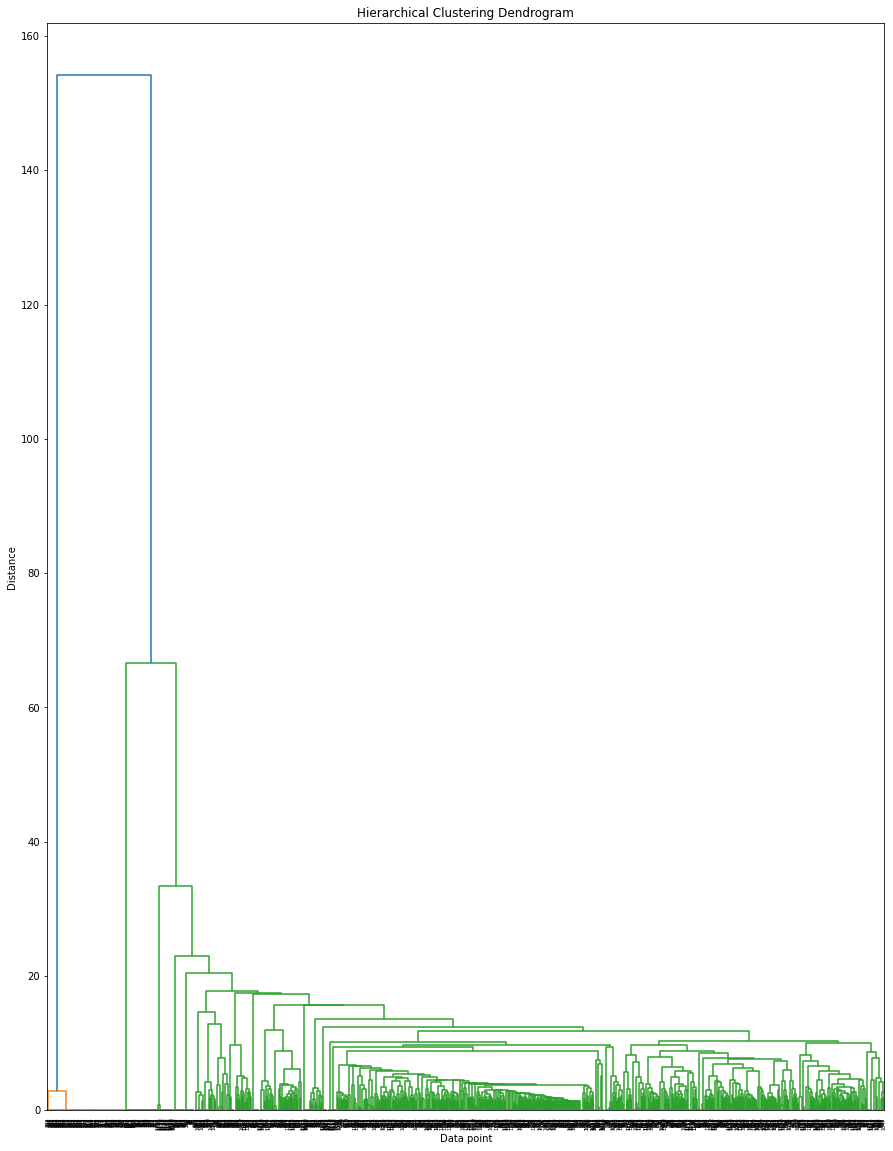

In [161]:
Z = linkage(similarity_matrix, 'ward')


plt.figure(figsize=(15, 20))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)

### Dendrogram Analysis
- This dendrogram shows how much more difficult it was to cluster the tweets for the Western conference. It looks like a lot of grouping were made on Tweets not really related to the game. We also saw this in our word clouds for both the Phoenix Suns and the Dallas Mavericks. The most prominent words had to do with giveaways, NFT collections, and sports betting. 

# Conclusions

In this project I wanted to scrape tweets related to two series currently happening in the NBA right. I used those tweets to create word clouds of the 50 most popular words related to each team hashtag. After that, I tried to cluster the tweets into groups based on their similarities. This was accomplished through K-means clustering and HCA. Here were my findings from each step of my analysis:

- Word Clouds:
    * Bucks fans tweeted about Giannis Antetokounmpo their best player and Al Horford the opposing teams best player who played exceptionally well in the series so far. 
    * Celtics fans also tweeted about Al Horford, but also tweeted about the refs and the big comeback in Game 5 by the Bucks.
    * Suns fans tweeted about ticket giveaways, retweeting, and Chris Paul
    * Mavs fans tweeted about NFT collections, betting, and but I suspect the hashtag used to scrape in Tweets wasn't a good hashtag. 
- Clustering:
    * The clusters generated for the Eastern Conference had pretty clear clusters and the words within most of the clusters seemed to be related. The best cluster was the final one which talked about the broadcast of the game. 
    * The clusters generated for the Western conference were not very strong in their accuracy. This could be because of the excessive amount of people tweeting about giveaways or NFT's, or sports betting. 
    
## Next steps:
- This project was interesting. Some next steps for project ideas could be:
    * sentiment analysis
    * visualiz